In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import glob

from datetime import datetime, date

## To-do list
- Get clear on accuracy formula and calculations
- Standard deviations
- Optimization
- Repeat using a (non-deep learning) classifier of your choice.
- Discussions

In [2]:
def computeHoG(image, winSize, blockSize, blockStride, cellSize,
                               nbins, RESIZE_DIM, cell_size, block_size):
    
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

    n_cells = (RESIZE_DIM // cell_size[0], RESIZE_DIM // cell_size[1])

    # Compute HoG features
    hog_feats = hog.compute(image)
    hog_feats = hog_feats.reshape(n_cells[1]-block_size[1]+1,
                                  n_cells[0]-block_size[0]+1,
                                  block_size[0], block_size[1], nbins)
    hog_feats = hog_feats.transpose((1, 0, 2, 3, 4))  # index blocks by rows first

    # hog_feats now contains the gradient amplitudes for each direction,
    #for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    for off_y in range(block_size[0]):
        for off_x in range(block_size[1]):
            gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                      off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                       off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

    # Average gradients
    gradients /= cell_count

    gradients = gradients.reshape((1, -1))
    return gradients

def resizeImage(image, dimension):
    imy, imx = image.shape[0:2]
    M = np.float32([[dimension/imx, 0, 0], [0, dimension/imy, 0]])
    image = cv2.warpAffine(image, M, (RESIZE_DIM, RESIZE_DIM))
    return image

In [3]:
#displaay
startGlobal = datetime.time(datetime.now())

# #testing
categoriesTest  = [
#      "car",
#      "background",
#      "pickup_truck",
#     "articulated_truck",
#     "bus",
     "work_van",
     "pedestrian",
    "single_unit_truck",
    "bicycle",
    "motorcycle",
    "non-motorized_vehicle"]
#endTesting
#^We notice that runtime is minimized of operations occur on the largest categories first
numCategories = len(categoriesTest)

#TEMP
sumIm = 0
for i in range(numCategories):
    path = ("MIO-TCD-Classification/train/%s/*.jpg" % categoriesTest[i])
    numImages = len(glob.glob(path))
    sumIm = sumIm + numImages
#End TEMP

RESIZE_DIM = 64
# totalNumIm = 519164 #MAY GIVE MEMORY ERROR
#testing
totalNumIm = sumIm
#End testing
globalImCtr = 0

#HoG variables
#Raw variables
cell_size = (4,4)
block_size = (4, 4)

#variables for computation
winSize = (RESIZE_DIM // cell_size[1] * cell_size[1], RESIZE_DIM // cell_size[0] * cell_size[0] )
blockSize = (block_size[1] * cell_size[1], block_size[0] * cell_size[0])
blockStride = (cell_size[1], cell_size[0])
cellSize = (cell_size[1], cell_size[0])
nbins = 8
#End HoG variables

totalNumFeatures = RESIZE_DIM // cell_size[1] * RESIZE_DIM // cell_size[0] * nbins

#array initialization
labelsArray = np.zeros(totalNumIm, dtype=np.int)
featuresArray = np.zeros((totalNumIm, totalNumFeatures))
indexArray = np.arange(totalNumIm, dtype=np.int)
np.random.shuffle(indexArray)         

# Read input images category by category
for i in range(numCategories):
    start = datetime.time(datetime.now())

    #specifying path to images
    path = ("MIO-TCD-Classification/train/%s/*.jpg" % categoriesTest[i])

    #Variable initializations
    categoryImgCnt = 0
    nextPctg = 5
    numImages = len(glob.glob(path))

    #display
    print("Loading Images for category:    >>>" + categoriesTest[i] + "<<<    " + str(numImages) + " images")
    print("    Percentage Completed: 0%-", end='')

    # for each image in the category folder
    for file in glob.glob(path):
        #read, convert color, get features, stor info
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #resizing IF NECESSARY
        #TRY to do HoG without resizing image. to be discussed
        image = resizeImage(image, RESIZE_DIM)
        #end resize
        
        #Computing features
        #HoG features
        gradients = computeHoG(image, winSize, blockSize, blockStride, cellSize,
                               nbins, RESIZE_DIM, cell_size, block_size)

        randomIndex = indexArray[globalImCtr]
        featuresArray[randomIndex] = gradients
        labelsArray[randomIndex] = i
        #End Feature computation
        
        #variable update
        globalImCtr = globalImCtr + 1
        categoryImgCnt = categoryImgCnt + 1
        
        #display
        if (int(categoryImgCnt*100/numImages)) == nextPctg:
            print(str(nextPctg) + "%", end='')
            if nextPctg != 100 : print("-", end='')
            nextPctg = nextPctg + 5
    #display        
    print("")
    end = datetime.time(datetime.now())
    print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))

#display
endGlobal = datetime.time(datetime.now())
duration = datetime.combine(date.today(), endGlobal) - datetime.combine(date.today(), startGlobal)
print(">Total duration: " + str(duration))
print(labelsArray[:100])

Loading Images for category:    >>>work_van<<<    9679 images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:13.481310
Loading Images for category:    >>>pedestrian<<<    6262 images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:07.039984
Loading Images for category:    >>>single_unit_truck<<<    5120 images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:08.019426
Loading Images for category:    >>>bicycle<<<    2284 images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:02.695463
Loading Images for category:    >>>motorcycle<<<    1982 images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:0

In [4]:
print("Size of featuresArray: ", featuresArray.shape)
print("Size of labelsArray: ", labelsArray.shape)

Size of featuresArray:  (27078, 2048)
Size of labelsArray:  (27078,)


Updates:
  Note: 
    Precision: Of the predictions made for class C, what fraction was correct?
    Recall: ”Of the samples for class C, how many were correctly predicted?
  Creating classifier 0
    Duration: 0:12:13.021430
  Getting predictions for classifier 0
    Duration: 0:01:15.706828
  Accuracy for subset 0 is 37 percent
  For subset 0:
    For class work_van: TP=899, FP=307, FN=109, TN=1392
      Accuracy = 84.63%      Precision = 74.54%      Recall = 89.19%

    For class pedestrian: TP=574, FP=182, FN=80, TN=1871
      Accuracy = 90.32%      Precision = 75.93%      Recall = 87.77%

    For class single_unit_truck: TP=266, FP=155, FN=193, TN=2093
      Accuracy = 87.14%      Precision = 63.18%      Recall = 57.95%

    For class bicycle: TP=133, FP=25, FN=107, TN=2442
      Accuracy = 95.12%      Precision = 84.18%      Recall = 55.42%

    For class motorcycle: TP=86, FP=34, FN=84, TN=2503
      Accuracy = 95.64%      Precision = 71.67%      Recall = 50.59%

    For class n

  Creating classifier 9
    Duration: 0:12:18.944390
  Getting predictions for classifier 9
    Duration: 0:01:16.299984
  Creating confusion matrix 9
    Duration: 0:00:00.002998


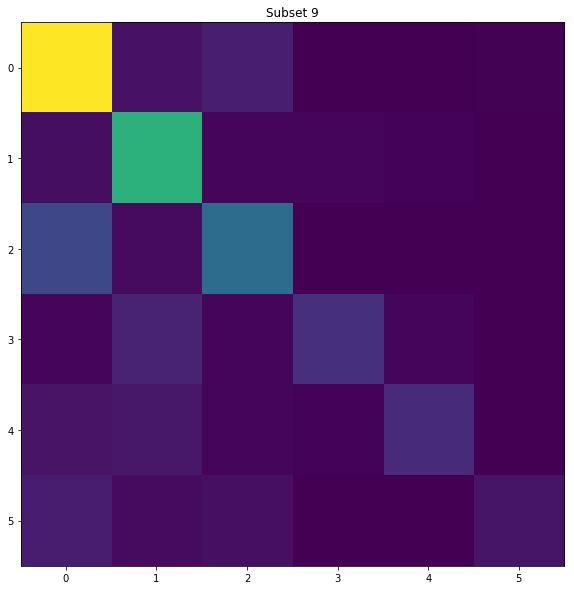

  Accuracy for subset 9 is 35 percent
  For subset 9:
    For class work_van: TP=841, FP=335, FN=120, TN=1411
      Accuracy = 83.19%      Precision = 71.51%      Recall = 87.51%

    For class pedestrian: TP=541, FP=229, FN=68, TN=1869
      Accuracy = 89.03%      Precision = 70.26%      Recall = 88.83%

    For class single_unit_truck: TP=298, FP=140, FN=210, TN=2059
      Accuracy = 87.07%      Precision = 68.04%      Recall = 58.66%

    For class bicycle: TP=114, FP=26, FN=119, TN=2448
      Accuracy = 94.64%      Precision = 81.43%      Recall = 48.93%

    For class motorcycle: TP=99, FP=25, FN=120, TN=2463
      Accuracy = 94.64%      Precision = 79.84%      Recall = 45.21%

    For class non-motorized_vehicle: TP=48, FP=11, FN=129, TN=2519
      Accuracy = 94.83%      Precision = 81.36%      Recall = 27.12%

  Accuracy2 for subset 9 = 90.57
  Average accuracy is 23
Done, total duration: 2:14:54.950968


In [5]:
print("Updates:")

print("  Note: ")
print("    Precision: Of the predictions made for class C, what fraction was correct?")
print("    Recall: ”Of the samples for class C, how many were correctly predicted?")

realStart = datetime.time(datetime.now())

numSubset = 10

subsetSize = featuresArray.shape[0]//numSubset
    
# predictionsArray = []
    
accuracyArray = []
    
for subsetIndex in range(numSubset):
    data_test = featuresArray[subsetIndex*subsetSize:(subsetIndex+1)*subsetSize]
    labels_test = labelsArray[subsetIndex*subsetSize:(subsetIndex+1)*subsetSize]
    
    data_train = np.concatenate((featuresArray[:subsetIndex*subsetSize], 
                                 featuresArray[(subsetIndex+1)*subsetSize:]), axis = 0)
    labels_train = np.concatenate((labelsArray[:subsetIndex*subsetSize], 
                                   labelsArray[(subsetIndex+1)*subsetSize:]), axis = 0)

#     print("data_train shape:", data_train.shape)
#     print("d")
    
    print("\n  Creating classifier " + str(subsetIndex))
    start = datetime.time(datetime.now())
    clf = svm.SVC(C = 100.) # default kernel='rfb'
    clf.fit(data_train, labels_train)
    end = datetime.time(datetime.now())
    print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
    
    print("  Getting predictions for classifier " + str(subsetIndex))
    start = datetime.time(datetime.now())
    prediction = clf.predict(data_test)
    end = datetime.time(datetime.now())
    print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
    
    # Confusion Matrix
    ################################################
    # Do we only need one?
    ################################################
    if subsetIndex == numSubset-1:
        print("  Creating confusion matrix " + str(subsetIndex))
        start = datetime.time(datetime.now())
        confMat = confusion_matrix(labels_test, prediction)
        end = datetime.time(datetime.now())
        print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))

        plt.figure(figsize=(10,10))
        plt.imshow(confMat), plt.title("Subset " + str(subsetIndex))
        plt.show()
    
    # Accuracy
    Accuracy = 0
    predictions = prediction[0]
    Accuracy = np.sum(predictions == labels_test)
    Accuracy /= (subsetSize/100)
    accuracyArray.append(Accuracy)
    print("  Accuracy for subset %i is %i percent" % (subsetIndex, Accuracy))
    
    # Precision
    # for each class, get the precision (then average of all classes for all subset?)
    print("  For subset " + str(subsetIndex) + ":")
    
#     print("prediction shape:", prediction.shape)
    
    totalTP = 0
    totalTN = 0
    
#     print("  Note: ")
#     print("    Precision: Of the predictions made for class C, what fraction was correct?")
#     print("    Recall: ”Of the samples for class C, how many were correctly predicted?")
    
    for category in range(numCategories):
        TP = 0
        FP = 0
        FN = 0
        TN = 0
        for n in range(len(prediction)):
            if prediction[n] == category:
                if labels_test[n] == category:
                    # got a true positive
                    TP += 1
                    totalTP += 1
                else:
                    # got a false positive
                    FP += 1
                continue
                
            if prediction[n] != category:
                if labels_test[n] == category:
                    # got a false negative
                    FN += 1
                else:
                    # got a true negative
                    TN += 1
                    totalTN += 1
                continue
            
            else: print("    Error at n=" + str(n) + "-> Predicted: " + str(prediction[n])
                        + ", Correct: " + str(labels_test[n]))
        
        print("    For class " + str(categoriesTest[category]) + ": TP=" + str(TP) + ", FP=" + str(FP) 
              + ", FN=" + str(FN) + ", TN=" + str(TN))
        
        accuracyCalc = (TP+TN)/(TP+TN+FP+FN)*100
        precision = TP/(TP+FP)*100
        recall = TP/(TP+FN)*100
        
        print("      Accuracy = %.2f" % accuracyCalc + "%", end='')
        print("      Precision = %.2f" % precision + "%", end='')
        print("      Recall = %.2f" % recall + "%\n")
    
    subAcc = (totalTP+totalTN)/len(prediction)*100/numCategories
    print("  Accuracy2 for subset %i = %.2f" % (subsetIndex, subAcc))
    
    
# calculate the avg accuracy
avgAccuracy = 0
avgAccuracy = np.sum(accuracyArray)/len(accuracyArray)
print("  Average accuracy is %i" % (avgAccuracy))

realEnd = datetime.time(datetime.now())
print("Done, total duration: " + str(datetime.combine(date.today(), realEnd) - datetime.combine(date.today(), realStart)))

In [6]:
# # Based on code given in tutorial9 and sklearn_intro
# # split data: 70% into train, 30% into test
# print("Updates:")
# print("  Splitting data")

# data_train, data_test, labels_train, labels_test = train_test_split(featuresArray, labelsArray, train_size=0.7)
# # print(data_train.shape)

# # train SVM classifier
# print("  Creating classifier 1")
# startC1 = datetime.time(datetime.now())
# # startC1 = timer()
# classifier1 = svm.SVC() # default kernel='rfb', default C=1.0
# classifier1.fit(data_train, labels_train)
# # endC1 = timer() - startC1
# # print("    Duration: %f seconds" % (endC1))
# endC1 = datetime.time(datetime.now())
# print("    Duration: " + str(datetime.combine(date.today(), endC1) - datetime.combine(date.today(), startC1)))

# print("  Creating classifier 2")
# startC2 = datetime.time(datetime.now())
# classifier2 = svm.SVC(kernel='poly')
# classifier2.fit(data_train, labels_train)
# endC2 = datetime.time(datetime.now())
# print("    Duration: " + str(datetime.combine(date.today(), endC2) - datetime.combine(date.today(), startC2)))

# print("  Creating classifier 3")
# startC3 = datetime.time(datetime.now())
# classifier3 = svm.SVC(C = 100.) # default kernel='rfb'
# classifier3.fit(data_train, labels_train)
# endC3 = datetime.time(datetime.now())
# print("    Duration: " + str(datetime.combine(date.today(), endC3) - datetime.combine(date.today(), startC3)))

# print("  Creating classifier 4")
# startC4 = datetime.time(datetime.now())
# classifier4 = svm.SVC(kernel='poly', C = 100.)
# classifier4.fit(data_train, labels_train)
# endC4 = datetime.time(datetime.now())
# print("    Duration: " + str(datetime.combine(date.today(), endC4) - datetime.combine(date.today(), startC4)))

# print("  Creating classifier 5")
# startC5 = datetime.time(datetime.now())
# classifier5 = svm.SVC(kernel='sigmoid') # default kernel='rfb'
# classifier5.fit(data_train, labels_train)
# endC5 = datetime.time(datetime.now())
# print("    Duration: " + str(datetime.combine(date.today(), endC5) - datetime.combine(date.today(), startC5)))

# print("  Creating classifier 6")
# startC6 = datetime.time(datetime.now())
# classifier6 = svm.SVC(kernel='sigmoid', C = 100.)
# classifier6.fit(data_train, labels_train)
# endC6 = datetime.time(datetime.now())
# print("    Duration: " + str(datetime.combine(date.today(), endC6) - datetime.combine(date.today(), startC6)))

# # get predictions of the classifier
# print("  Prediction with classifier 1")
# prediction1 = classifier1.predict(data_test)

# print("  Prediction with classifier 2")
# prediction2 = classifier2.predict(data_test)

# print("  Prediction with classifier 3")
# prediction3 = classifier3.predict(data_test)

# print("  Prediction with classifier 4")
# prediction4 = classifier4.predict(data_test)

# print("  Prediction with classifier 5")
# prediction5 = classifier5.predict(data_test)

# print("  Prediction with classifier 6")
# prediction6 = classifier6.predict(data_test)

# # create confusion matrix
# print("  Creating confusion matrix 1")
# conf_M1 = confusion_matrix(labels_test, prediction1)

# print("  Creating confusion matrix 2")
# conf_M2 = confusion_matrix(labels_test, prediction2)

# print("  Creating confusion matrix 3")
# conf_M3 = confusion_matrix(labels_test, prediction3)

# print("  Creating confusion matrix 4")
# conf_M4 = confusion_matrix(labels_test, prediction4)

# print("  Creating confusion matrix 5")
# conf_M5 = confusion_matrix(labels_test, prediction5)

# print("  Creating confusion matrix 6")
# conf_M6 = confusion_matrix(labels_test, prediction6)

# plt.figure(figsize=(15,15))
# plt.subplot(141), plt.imshow(conf_M1)
# plt.title("rfb kernel, C=1.0")
# plt.subplot(142), plt.imshow(conf_M2)
# plt.title("poly kernel, C=1.0")
# plt.subplot(143), plt.imshow(conf_M3)
# plt.title("rfb kernel, C=100")
# plt.subplot(144), plt.imshow(conf_M4)
# plt.title("poly kernel, C=100")
# plt.show()

# plt.figure(figsize=(15,15))
# plt.subplot(121), plt.imshow(conf_M5)
# plt.title("sigmoid kernel, C=1.0")
# plt.subplot(122), plt.imshow(conf_M6)
# plt.title("sigmoid kernel, C=100")
# plt.show()

In [7]:
# numSubset = 10
# subsetSize = featuresArray.shape[0]//numSubset

# #TESTING
# print("classification begins")
# for subsetIndex in range(numSubset):
#     classifier = svm.SVC(C = 100.) #By default: kernel  = 'rfb'
#     classifier.fit(np.concatenate((featuresArray[:subsetIndex*subsetSize], 
#                                    featuresArray[(subsetIndex+1)*subsetSize:]), axis = 0)
#                    , np.concatenate((labelsArray[:subsetIndex*subsetSize], 
#                                    labelsArray[(subsetIndex+1)*subsetSize:]), axis = 0))
#     #Takes long because too many features per image (cuz image large)
#     #PREDICTION
#     Accuracy = 0
#     prediction = classifier.predict(featuresArray[subsetIndex*subsetSize:(subsetIndex+1)*subsetSize])[0]
#     Accuracy = np.sum(prediction == labelsArray[subsetIndex*subsetSize:(subsetIndex+1)*subsetSize])
#     Accuracy /= (subsetSize/100)
#     print("Accuracy for subset %i is %i percent" % (subsetIndex, Accuracy))
# print("classification finished")
# #END TESTING